# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        idx = self.word2id.get(word,"xxxxdefaultxxxx")
        if idx == "xxxxdefaultxxxx":
            return np.zeros(self.embeddings[0].shape)
        return self.embeddings[idx]
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        e1, e2 = self.encode(word1), self.encode(word2)
        return np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        scores = np.zeros(len(self.words))
        for id,word2 in enumerate(self.words):
            if word2 != word:
                scores[id] = self.score(word,word2)
        return list(reversed([self.words[x] for x in scores.argsort()[-k:]]))

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976381
Paris France 0.689295892580654
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348002
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [5]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        self.idf = {}
        N = len(sentences)
        
        # first pass to count unique occurences of words in each sentence
        for sent in sentences:
            words = sent.replace(".","").lower().strip().split(" ")
            words = np.unique(words)
            for word in words:
                self.idf[word] = self.idf.get(word,0) + 1
        # second pass to compute the inverse frequencies
        for idx in self.idf.keys():
            self.idf[idx] = np.log(N / self.idf.get(idx,1)) 
            
        return self.idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        words = sentence.replace(".","").lower().strip().split(" ")
        if idf is None:
            # mean of word vectors
            return np.mean(np.vstack([self.word2vec.encode(word) for word in words]),axis=0)
        else:
            # idf-weighted mean of word vectors
            return np.mean(np.vstack([self.word2vec.encode(word)*idf.get(word,0) for word in words]),axis=0)

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        e1, e2 = self.encode(sentence1, idf), self.encode(sentence2, idf)
        return np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        scores = list([self.score(sentence, sentence2, idf) for sentence2 in sentences])
        idxs = np.argsort(scores)[-k:]
        return list(reversed([sentences[i] for i in idxs]))

In [6]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=100000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 100000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6412959133125588
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) 3 males and 1 woman enjoying a sporting event 
5) 2 chinese people wearing traditional clothes 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6394336233340874
2 chinese people wearing traditional clothes 
1) 2 chinese people wearing traditional clothes 
2) 3 men in tuxedos and 2 women in dresses , sleeping on the grass . 
3) 2 women in red outfits and 3 other people are standing at a street corner . 
4) 2 white ladies in casual clothing . 
5) 2 woman dancing while pointing . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        #intersection of dictionary keys
        shared_keys = self.fr_word2vec.word2id.keys() & self.en_word2vec.word2id.keys()
        #print(len(shared_keys))
        X = np.vstack([self.fr_word2vec.encode(key) for key in shared_keys]).T
        Y = np.vstack([self.en_word2vec.encode(key) for key in shared_keys]).T
        #print(X.shape, Y.shape)
        assert X.shape[0] == 300 and Y.shape[0] == 300
        assert X.shape[1] == Y.shape[1]
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U,Sig,Vt = np.linalg.svd(Y@X.T)
        W = U@Vt
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        idx = self.fr_word2vec.word2id[fr_word]
        fr_emb = self.aligned_fr_embeddings[idx]
        en_embs = self.en_word2vec.embeddings
        scores = en_embs @ fr_emb.reshape((-1,1))
        #print(en_embs.shape, fr_emb.shape, scores.shape,np.linalg.norm(en_embs,axis=1).shape)
        scores /= np.linalg.norm(fr_emb)
        scores /= np.linalg.norm(en_embs,axis=1)[:,None]
        scores = scores.ravel()
        #print(np.unique(scores, return_counts=True))
        return list(reversed([self.en_word2vec.id2word[x] for x in scores.argsort()[-k:]]))

In [8]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [9]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

def filtering(lines):
    X = []
    y = []
    for line in lines:
        y.append(int(line[0]))
        X.append(line[2:])
    return X,y

with open(train_filepath,"r") as f:
    train_lines = f.readlines()
with open(dev_filepath,"r") as f:
    dev_lines = f.readlines()
with open(test_filepath,"r") as f:
    test_lines = f.readlines()
    
train_lines, y_train = filtering(train_lines)
dev_lines, y_dev = filtering(dev_lines)
print(np.unique(y_train,return_counts=True))

(array([0, 1, 2, 3, 4]), array([1092, 2218, 1624, 2322, 1288]))


In [10]:
# 2 - Encode sentences with the BoV model above

word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
bow = BagOfWords(word2vec)
idf = bow.build_idf(train_lines)
x_train = np.vstack([bow.encode(line,idf=None) for line in train_lines]) 
x_dev = np.vstack([bow.encode(line,idf=None) for line in dev_lines])  
x_test = np.vstack([bow.encode(line,idf=None) for line in test_lines]) 
x_train_idf = np.vstack([bow.encode(line,idf=idf) for line in train_lines]) 
x_dev_idf = np.vstack([bow.encode(line,idf=idf) for line in dev_lines])  
x_test_idf = np.vstack([bow.encode(line,idf=idf) for line in test_lines])   

print(x_train.shape)

Loaded 50000 pretrained word vectors
(8544, 300)


C= 0.001 => 0.254314259763851
C= 0.01 => 0.3097184377838329
C= 0.1 => 0.35876475930971846
C= 1.0 => 0.40236148955495005
C= 10.0 => 0.4087193460490463


/home/leo/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


C= 100.0 => 0.4087193460490463
C= 0.001 => 0.254314259763851
C= 0.01 => 0.3097184377838329
C= 0.1 => 0.35876475930971846
C= 1.0 => 0.40236148955495005
C= 10.0 => 0.4087193460490463
C= 100.0 => 0.4087193460490463


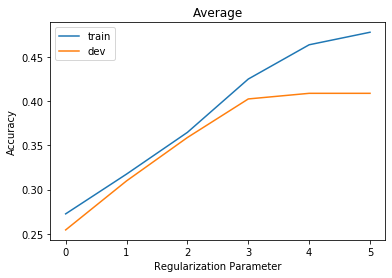

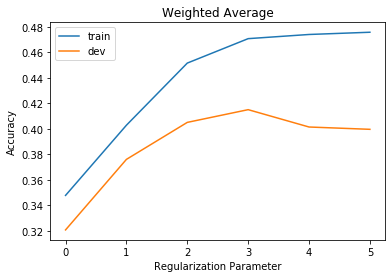

In [11]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

from sklearn.linear_model import LogisticRegression

regs = np.logspace(-3,2,6)
scores = np.zeros((2,len(regs)))
for i, reg in enumerate(regs):
    lr = LogisticRegression(C=reg,solver="lbfgs",multi_class="auto",max_iter=1000)
    lr.fit(x_train,y_train)
    scores[0,i] = lr.score(x_train,y_train)
    scores[1,i] = lr.score(x_dev,y_dev)
    print("C=",reg,"=>",scores[1,i])
    
scores_idf = np.zeros((2,len(regs)))
for i, reg in enumerate(regs):
    lr = LogisticRegression(C=reg,solver="lbfgs",multi_class="auto",max_iter=1000)
    lr.fit(x_train_idf,y_train)
    scores_idf[0,i] = lr.score(x_train_idf,y_train)
    scores_idf[1,i] = lr.score(x_dev_idf,y_dev)
    print("C=",reg,"=>",scores[1,i])
    
plt.figure()
plt.plot(scores[0],label="train")
plt.plot(scores[1],label="dev")
plt.xlabel("Regularization Parameter")
plt.ylabel("Accuracy")
plt.title("Average")
plt.legend()
plt.figure()
plt.plot(scores_idf[0],label="train")
plt.plot(scores_idf[1],label="dev")
plt.xlabel("Regularization Parameter")
plt.ylabel("Accuracy")
plt.title("Weighted Average")
plt.legend()
plt.show()

In [40]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.
lr = LogisticRegression(C=regs[np.argmax(scores)],solver="lbfgs",multi_class="auto",max_iter=1000)
lr.fit(x_train_idf,y_train)

with open("logreg_bov_y_test_sst.txt","w+") as f:
    y_pred = lr.predict(x_test_idf)
    for y in y_pred:
        f.write(str(y)+"\n")

In [11]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)
from sklearn.svm import SVC

regs = np.logspace(1,4,4)
scores = np.zeros(regs.shape)
for i, reg in enumerate(regs):
    svc = SVC(C=reg,kernel="rbf",gamma="auto")
    svc.fit(x_train_idf,y_train)
    scores[i] = svc.score(x_dev_idf,y_dev)
    print("C=",reg,"=>",scores[i])
    
SVC(C=regs[np.argmax(scores)],kernel="rbf",gamma="auto")
svc.fit(x_train_idf,y_train)

with open("svm_bov_y_test_sst.txt","w+") as f:
    y_pred = svc.predict(x_test_idf)
    for y in y_pred:
        f.write(str(y)+"\n")

C= 10.0 => 0.38419618528610355
C= 100.0 => 0.4114441416893733
C= 1000.0 => 0.41689373297002724
C= 10000.0 => 0.3823796548592189


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [3]:
import tensorflow as tf

In [4]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

def filtering(lines,test=False):
    X = []
    y = []
    for line in lines:
        if test:
            X.append(tf.keras.preprocessing.text.one_hot(line,n=10000))
        else:
            y.append(int(line[0]))
            X.append(tf.keras.preprocessing.text.one_hot(line[2:],n=10000))
    if not test:
        y = tf.keras.utils.to_categorical(y)
    return X,y

with open(train_filepath,"r") as f:
    train_lines = f.readlines()
with open(dev_filepath,"r") as f:
    dev_lines = f.readlines()
with open(test_filepath,"r") as f:
    test_lines = f.readlines()
    
x_train, y_train = filtering(train_lines)
x_dev, y_dev = filtering(dev_lines)
x_test, _ = filtering(test_lines, test=True)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [5]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=50)
x_dev = tf.keras.preprocessing.sequence.pad_sequences(x_dev, maxlen=50)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=50)

## 4.2 - Design and train your model

In [6]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 128  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 10000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(n_classes, activation='sigmoid',
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
                activity_regularizer=tf.keras.regularizers.l1(0.01)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 1,329,733
Trainable params: 1,329,733
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
# due to GPU issue on my computer

bs = 128
n_epochs = 6

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 11s 1ms/sample - loss: 1.6661 - acc: 0.2691 - val_loss: 1.6418 - val_acc: 0.2534
Epoch 2/6
8544/8544 [==============================] - 10s 1ms/sample - loss: 1.6008 - acc: 0.3159 - val_loss: 1.5547 - val_acc: 0.3515
Epoch 3/6
8544/8544 [==============================] - 10s 1ms/sample - loss: 1.4281 - acc: 0.3963 - val_loss: 1.4641 - val_acc: 0.3869
Epoch 4/6
8544/8544 [==============================] - 9s 1ms/sample - loss: 1.2605 - acc: 0.4539 - val_loss: 1.5047 - val_acc: 0.3778
Epoch 5/6
8544/8544 [==============================] - 10s 1ms/sample - loss: 1.1381 - acc: 0.5023 - val_loss: 1.5538 - val_acc: 0.3842
Epoch 6/6
8544/8544 [==============================] - 10s 1ms/sample - loss: 1.0271 - acc: 0.5787 - val_loss: 1.6219 - val_acc: 0.3724


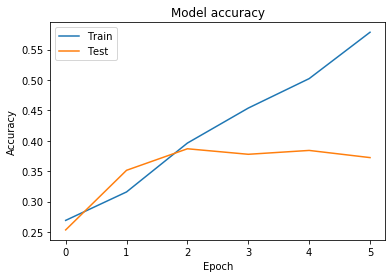

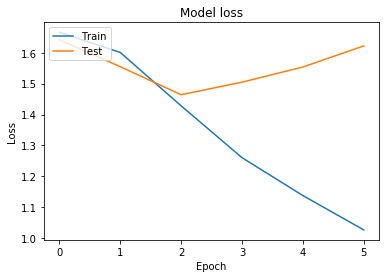

In [9]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

with open("logreg_lstm_y_test_sst.txt","w+") as f:
    y_pred = np.argmax(model.predict(x_test),1)
    for y in y_pred:
        f.write(str(y)+"\n")

## 4.3 - innovate !

Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 5s 547us/sample - loss: 1.6706 - acc: 0.2573 - val_loss: 1.6460 - val_acc: 0.2670
Epoch 2/10
8544/8544 [==============================] - 4s 512us/sample - loss: 1.6415 - acc: 0.2768 - val_loss: 1.6335 - val_acc: 0.2607
Epoch 3/10
8544/8544 [==============================] - 4s 480us/sample - loss: 1.6246 - acc: 0.2701 - val_loss: 1.6194 - val_acc: 0.2652
Epoch 4/10
8544/8544 [==============================] - 4s 490us/sample - loss: 1.6009 - acc: 0.2741 - val_loss: 1.6080 - val_acc: 0.2643
Epoch 5/10
8544/8544 [==============================] - 4s 501us/sample - loss: 1.5496 - acc: 0.2766 - val_loss: 1.6053 - val_acc: 0.2443
Epoch 6/10
8544/8544 [==============================] - 4s 497us/sample - loss: 1.4731 - acc: 0.2952 - val_loss: 1.6308 - val_acc: 0.2352
Epoch 7/10
8544/8544 [==============================] - 4s 503us/sample - loss: 1.3858 - acc: 0.3147 - val_loss: 1.7525 - va

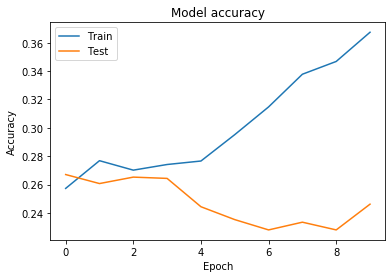

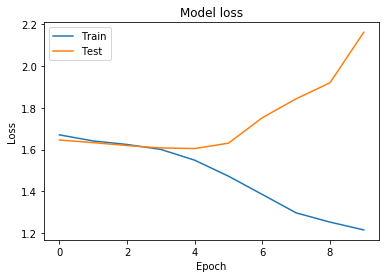

In [10]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from tensorflow.keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D, Dropout

model2 = Sequential()
model2.add(Embedding(vocab_size, embed_dim, input_length=50))
model2.add(Conv1D(32, 5, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Conv1D(16, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Flatten())
model2.add(Dense(n_classes*3, activation='relu'))
model2.add(Dropout(0.8))
model2.add(Dense(n_classes, activation='sigmoid',
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
                activity_regularizer=tf.keras.regularizers.l1(0.01)))

bs = 128
n_epochs = 10
model2.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
history2 = model2.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev))

with open("regularized_cnn_y_test_sst.txt","w+") as f:
    y_pred = np.argmax(model2.predict(x_test),1)
    for y in y_pred:
        f.write(str(y)+"\n")
        
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()